# SPM - Face rep tutorial example reproduction on nipype 

This notebook reproduce the Famous vs Non Famous Face example of Single Subject Analysis. The original pipeline can be found on SPM12 manual [here](https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf).

This tutorial was reproduced by adapting some of SPM options on nipype. 

Images were first pretreated to be compatible with nipype's commands. 
Dataset can be found [here](https://www.fil.ion.ucl.ac.uk/spm/data/face_rep/). 

In [39]:
# Set the path to matlab 
## NECESSARY TO USE SPM
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7771/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [40]:
from nipype.interfaces.spm import RealignUnwarp, SliceTiming, Smooth, Coregister, NewSegment, Normalize12
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node, MapNode
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os

In [41]:
# REPOSITORIES TO STORE FILES 
exp_dir = "/home/reproduced_tutorial/face_rep/face_rep"
output_dir = "datasink"
working_dir = "workingdir"

In [42]:
# BASIC VARIABLES
fwhm = 6
TR = 2 
TA = 1.92

In [43]:
# NODE AND TEMPLATE FOR SELECTING FILES 
anat_file = opj('Structural', 'sM03953_0007.img')
func_file = opj('RawEPI', 'sM03953_0005_*.img')

templates = {'anat':anat_file,
            'func':func_file}

selectfiles = Node(SelectFiles(templates, base_directory = exp_dir), name = "selectfiles")

In [44]:
# NODE FOR OUTPUT FILES (store the wanted results in the wanted repository)
datasink = Node(DataSink(base_directory=exp_dir, container=output_dir), name='datasink')

In [45]:
def pretreat_data(fnames):
    '''
    Pretreatment of .img/.hdr data to get a .nii 4D file. 
    '''
    import nibabel as nib
    import numpy as np
    from os.path import join as opj

    for f in fnames:
        img = nib.load(f)
        nib.save(img, f.replace('.img', '.nii'))

    f_nii_names = [f"/home/reproduced_tutorial/face_rep/face_rep/RawEPI/sM03953_0005_{i}.nii" for i in ['0' * (4-len(str(j))) + str(j) for j in range(6, 357)]]
    for f in f_nii_names:
        img = nib.load(f)
        imgs_4D = nib.four_to_three(img)
        nib.save(imgs_4D[0], f)

    img_4D = nib.concat_images(f_nii_names, check_affines = False, axis = None)
    
    new_fname = opj('/home', 'reproduced_tutorial', 'face_rep', '4D_img.nii')
    nib.save(img_4D, new_fname)
    
    return new_fname

In [46]:
pretreat = Node(Function(input_names = ['fnames'], output_names = ['new_fname'],
                        function = pretreat_data), name = 'pretreat')

In [47]:
# NODES FOR THE MAIN WORKFLOW 
## Realignment
realign = Node(RealignUnwarp(), name='realign')

## Slice timing
slice_timing = Node(SliceTiming(num_slices = 24, time_repetition = TR, time_acquisition = TA, 
                                slice_order = [i for i in range(24, 0, -1)], ref_slice = 12), 
                    name = 'slice_timing')

## Normalization
norm_anat = Node(Normalize12(jobtype = 'write', write_voxel_sizes = [1, 1, 1]), name = 'norm_anat')

norm_func = Node(Normalize12(jobtype = 'write', write_voxel_sizes = [3, 3, 3]), name = 'norm_func')

def get_vox_dims(volume):
    ''' 
    Function that gives the voxel dimension of an image. 
    Not used here but if we use it, modify the connection to : 
    (slice_timing, normalize_func, [('timecorrected_files', 'apply_to_files'),
                                    (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')])
    '''
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

## Smoothing
smooth = Node(Smooth(fwhm = fwhm), name = 'smooth')

In [48]:
# COREGISTRATION + SEGMENT WORKFLOW TO RUN IN PARALLEL
## Coregistration 
coreg = Node(Coregister(), name = 'coreg')

## Segmentation 
seg = Node(NewSegment(write_deformation_fields = [False, True], channel_info = (0.0001, 60, (True, True))), name = 'seg')

## Definition of the WorkFlow
coregwf = Workflow(name = 'coregwf')
coregwf.base_dir = opj(exp_dir, working_dir)

## Connection of nodes inside the workflow 
coregwf.connect([(coreg, seg, [('coregistered_source', 'channel_files')])])

In [49]:
# DEFINITION OF THE MAIN WORKFLOW
preprocess = Workflow(name='preprocess')
preprocess.base_dir = opj(exp_dir, working_dir)

# CONNECTION OF NODES INSIDE THE WORKFLOW
preprocess.connect([(selectfiles, pretreat, [('func', 'fnames')]),
                   (pretreat, realign, [('new_fname', 'in_files')]),
                   (realign, slice_timing, [('realigned_unwarped_files', 'in_files')]),
                   (realign, coregwf, [('mean_image', 'coreg.target')]),
                   (selectfiles, coregwf, [('anat', 'coreg.source')]),
                   (coregwf, norm_func, [('seg.forward_deformation_field', 'deformation_file')]),
                   (slice_timing, norm_func, [('timecorrected_files', 'apply_to_files')]),
                   (coregwf, norm_anat, [('seg.forward_deformation_field', 'deformation_file'), 
                                        ('seg.bias_corrected_images', 'apply_to_files')]),
                    (norm_func, smooth, [('normalized_files', 'in_files')]),
                    (realign, datasink, [('realignment_parameters', 'preprocess.@par')]),
                    (coregwf, datasink, [('seg.transformation_mat', 'preprocess.@mat_file')]),
                    (norm_anat, datasink, [('normalized_files', 'preprocess@anat_norm')]),
                    (smooth, datasink, [('smoothed_files', 'preprocess@smooth')])
                   ])

210324-16:14:37,12 nipype.workflow INFO:
	 Generated workflow graph: /home/reproduced_tutorial/face_rep/face_rep/workingdir/preprocess/graph.png (graph2use=colored, simple_form=True).


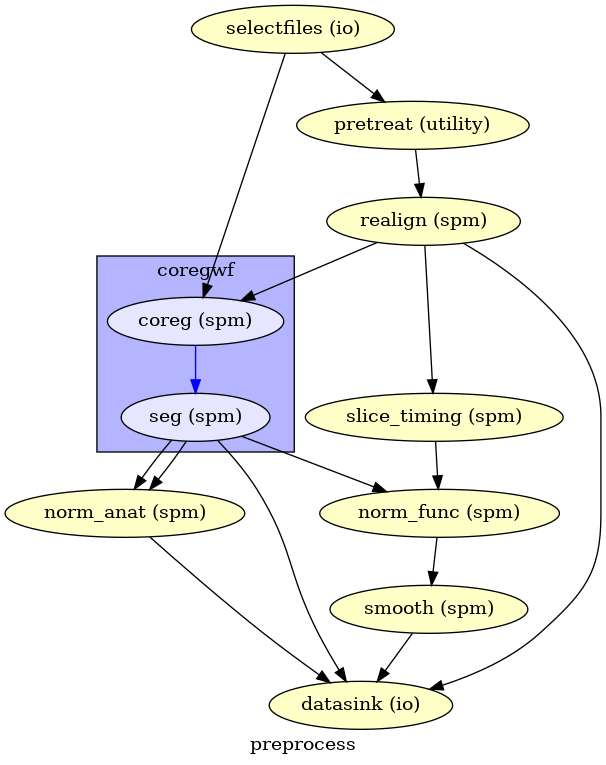

In [50]:
# Create preprocESS output graph
preprocess.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preprocess.base_dir, 'preprocess', 'graph.png'))

In [51]:
preprocess.run()

210324-16:14:37,34 nipype.workflow INFO:
	 Workflow preprocess settings: ['check', 'execution', 'logging', 'monitoring']
210324-16:14:37,46 nipype.workflow INFO:
	 Running serially.
210324-16:14:37,47 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/reproduced_tutorial/face_rep/face_rep/workingdir/preprocess/selectfiles".
210324-16:14:37,51 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210324-16:14:37,75 nipype.workflow INFO:
	 [Node] Finished "preprocess.selectfiles".
210324-16:14:37,76 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.pretreat" in "/home/reproduced_tutorial/face_rep/face_rep/workingdir/preprocess/pretreat".
210324-16:14:37,91 nipype.workflow INFO:
	 [Node] Running "pretreat" ("nipype.interfaces.utility.wrappers.Function")
210324-16:14:40,387 nipype.workflow INFO:
	 [Node] Finished "preprocess.pretreat".
210324-16:14:40,392 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.realign" in "/ho

In [52]:
realign_files = opj(output_dir, 'preprocess', 'rp_4D_img.txt')
smoothed_files = opj(output_dir, 'preprocess@smooth', 'swau4D_img.nii')

template = {'realign' : realign_files, 'smooth' : smoothed_files}

selectfiles = Node(SelectFiles(template, base_directory = exp_dir), name = 'selectfiles')

In [53]:
## GIVES THE MATRIX THAT CONTAINS THE TIMING OF THE TASK 
from scipy.io.matlab import loadmat
mat = loadmat(opj(exp_dir, "sots.mat"), struct_as_record=False)
sot = mat['sot'][0]
itemlag = mat['itemlag'][0]

In [54]:
## IMPORT 
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.base import Bunch 
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Threshold

In [56]:
# INFORMATIONS ON THE DESIGN
# We multiply onsets by 2 bc TR = 2 and we change input unit on 'secs' instead
subject_infos = Bunch(
        conditions=['N1', 'N2', 'F1', 'F2'],
        onsets=[[sot[0][i][0] *2 for i in range(len(sot[0]))], [sot[1][i][0] *2 for i in range(len(sot[1]))],
                [sot[2][i][0] *2 for i in range(len(sot[2]))], [sot[3][i][0] *2 for i in range(len(sot[3]))]],
        durations=[[0 for i in range(len(sot[0]))], [0 for i in range(len(sot[1]))], 
                   [0 for i in range(len(sot[2]))], [0 for i in range(len(sot[3]))]],
        amplitudes=None,
        tmod=None,
        pmod=None,
        regressor_names=None,
        regressors=None)


# CONTRASTS
cond1 = ('positive effect of condition', 'T',
         ['N1*bf(1)', 'N2*bf(1)', 'F1*bf(1)', 'F2*bf(1)'], [1, 1, 1, 1])
cond2 = ('positive effect of condition_dtemo', 'T',
         ['N1*bf(2)', 'N2*bf(2)', 'F1*bf(2)', 'F2*bf(2)'], [1, 1, 1, 1])
cond3 = ('positive effect of condition_ddisp', 'T',
         ['N1*bf(3)', 'N2*bf(3)', 'F1*bf(3)', 'F2*bf(3)'], [1, 1, 1, 1])
# non-famous > famous
fam1 = ('positive effect of Fame', 'T',
        ['N1*bf(1)', 'N2*bf(1)', 'F1*bf(1)', 'F2*bf(1)'], [1, 1, -1, -1])
fam2 = ('positive effect of Fame_dtemp', 'T',
        ['N1*bf(2)', 'N2*bf(2)', 'F1*bf(2)', 'F2*bf(2)'], [1, 1, -1, -1])
fam3 = ('positive effect of Fame_ddisp', 'T',
        ['N1*bf(3)', 'N2*bf(3)', 'F1*bf(3)', 'F2*bf(3)'], [1, 1, -1, -1])
# rep1 > rep2
rep1 = ('positive effect of Rep', 'T',
        ['N1*bf(1)', 'N2*bf(1)', 'F1*bf(1)', 'F2*bf(1)'], [1, -1, 1, -1])
rep2 = ('positive effect of Rep_dtemp', 'T',
        ['N1*bf(2)', 'N2*bf(2)', 'F1*bf(2)', 'F2*bf(2)'], [1, -1, 1, -1])
rep3 = ('positive effect of Rep_ddisp', 'T',
        ['N1*bf(3)', 'N2*bf(3)', 'F1*bf(3)', 'F2*bf(3)'], [1, -1, 1, -1])
int1 = ('positive interaction of Fame x Rep', 'T',
        ['N1*bf(1)', 'N2*bf(1)', 'F1*bf(1)', 'F2*bf(1)'], [-1, -1, -1, 1])
int2 = ('positive interaction of Fame x Rep_dtemp', 'T',
        ['N1*bf(2)', 'N2*bf(2)', 'F1*bf(2)', 'F2*bf(2)'], [1, -1, -1, 1])
int3 = ('positive interaction of Fame x Rep_ddisp', 'T',
        ['N1*bf(3)', 'N2*bf(3)', 'F1*bf(3)', 'F2*bf(3)'], [1, -1, -1, 1])

contf1 = ['average effect condition', 'F', [cond1, cond2, cond3]]
contf2 = ['main effect Fam', 'F', [fam1, fam2, fam3]]
contf3 = ['main effect Rep', 'F', [rep1, rep2, rep3]]
contf4 = ['interaction: Fam x Rep', 'F', [int1, int2, int3]]
contrasts = [cond1, cond2, cond3, fam1, fam2, fam3, rep1, rep2, rep3, int1, int2, int3, 
             contf1, contf2, contf3, contf4]

In [57]:
# ANALYSIS NODES
## Model specification
specify_model = Node(SpecifySPMModel(input_units='secs', subject_info = subject_infos, time_repetition = TR,
                                 high_pass_filter_cutoff = 120),
                         name = 'specify_model')
## Design level 1
l1design = Node(Level1Design(bases = {'hrf' : {'derivs' : [1,1]}}, interscan_interval = 2, 
                            timing_units = 'secs', microtime_resolution = 24, 
                            microtime_onset = 12), name = 'l1design')
## Estimate model
l1estimate = Node(EstimateModel(estimation_method = {'Classical' : 1}), name = 'l1estimate')

## Estimate contrast
contrast_estimate = Node(EstimateContrast(contrasts = contrasts, use_derivs=True), name = 'contrast_estimate')

## Thresholded maps
threshold = MapNode(Threshold(), name = 'threshold', iterfield = ['stat_image', 'contrast_index'])

In [58]:
def get_contrast_list():
    contrast_list = range(1, 17)
    return contrast_list

contrast_list = Node(Function(output_names = ['contrast_list'],
                             function = get_contrast_list), name = 'contrast_list')

In [59]:
analysis_non_param = Workflow(name = 'analysis_non_param')
analysis_non_param.base_dir = opj(exp_dir, working_dir)

analysis_non_param.connect([(selectfiles, specify_model, [('smooth', 'functional_runs'),
                                                         ('realign', 'realignment_parameters')]),
                            (specify_model, l1design, [('session_info', 'session_info')]),
                            (l1design, l1estimate, [('spm_mat_file', 'spm_mat_file')]),
                            (l1estimate, contrast_estimate, [('spm_mat_file', 'spm_mat_file'),
                                                            ('beta_images', 'beta_images'),
                                                            ('residual_image', 'residual_image')]),
                            (contrast_list, threshold, [('contrast_list', 'contrast_index')]),
                            (contrast_estimate, threshold, [('spm_mat_file', 'spm_mat_file'),
                                                            ('spmT_images','stat_image')])
                           ])

In [60]:
datasink_analysis = Node(DataSink(base_directory = exp_dir, container=output_dir), name = 'datasink_analysis')

analysis_non_param.connect([(contrast_estimate, datasink_analysis, [('con_images', 'analysis.@con_images'),
                                                                   ('spmT_images', 'analysis.@spmT_images'),
                                                                   ('spm_mat_file', 'analysis.@spm_mat_file')]),
                           (threshold, datasink_analysis, [('thresholded_map', 'analysis.@thresholded_map')])])

210324-16:21:29,675 nipype.workflow INFO:
	 Generated workflow graph: /home/reproduced_tutorial/face_rep/face_rep/workingdir/analysis_non_param/graph.png (graph2use=colored, simple_form=True).


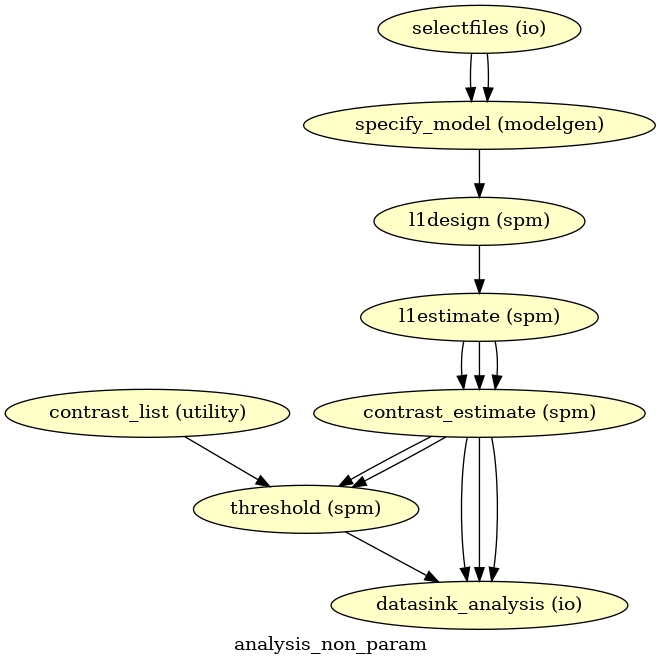

In [61]:
# Create analysis_non_param output graph
analysis_non_param.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(analysis_non_param.base_dir, 'analysis_non_param', 'graph.png'))

In [62]:
analysis_non_param.run()

210324-16:21:32,846 nipype.workflow INFO:
	 Workflow analysis_non_param settings: ['check', 'execution', 'logging', 'monitoring']
210324-16:21:32,859 nipype.workflow INFO:
	 Running serially.
210324-16:21:32,860 nipype.workflow INFO:
	 [Node] Setting-up "analysis_non_param.contrast_list" in "/home/reproduced_tutorial/face_rep/face_rep/workingdir/analysis_non_param/contrast_list".
210324-16:21:32,863 nipype.workflow INFO:
	 [Node] Running "contrast_list" ("nipype.interfaces.utility.wrappers.Function")
210324-16:21:32,867 nipype.workflow INFO:
	 [Node] Finished "analysis_non_param.contrast_list".
210324-16:21:32,868 nipype.workflow INFO:
	 [Node] Setting-up "analysis_non_param.selectfiles" in "/home/reproduced_tutorial/face_rep/face_rep/workingdir/analysis_non_param/selectfiles".
210324-16:21:32,871 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210324-16:21:32,874 nipype.workflow INFO:
	 [Node] Finished "analysis_non_param.selectfiles".
210324-

210324-16:22:35,844 nipype.workflow INFO:
	 [Node] Running "_threshold14" ("nipype.interfaces.spm.model.Threshold")
210324-16:22:38,282 nipype.workflow INFO:
	 [Node] Finished "_threshold14".
210324-16:22:38,285 nipype.workflow INFO:
	 [Node] Setting-up "_threshold15" in "/home/reproduced_tutorial/face_rep/face_rep/workingdir/analysis_non_param/threshold/mapflow/_threshold15".
210324-16:22:38,293 nipype.workflow INFO:
	 [Node] Running "_threshold15" ("nipype.interfaces.spm.model.Threshold")
210324-16:22:40,599 nipype.workflow INFO:
	 [Node] Finished "_threshold15".
210324-16:22:40,604 nipype.workflow INFO:
	 [Node] Finished "analysis_non_param.threshold".
210324-16:22:40,605 nipype.workflow INFO:
	 [Node] Setting-up "analysis_non_param.datasink_analysis" in "/home/reproduced_tutorial/face_rep/face_rep/workingdir/analysis_non_param/datasink_analysis".
210324-16:22:40,616 nipype.workflow INFO:
	 [Node] Running "datasink_analysis" ("nipype.interfaces.io.DataSink")
210324-16:22:40,627 nipy

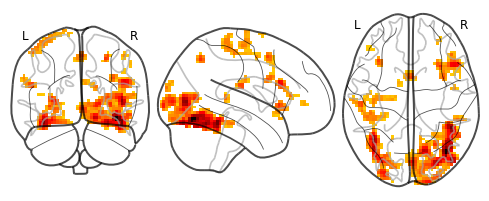

In [65]:
plotting.plot_glass_brain('/home/reproduced_tutorial/face_rep/face_rep/datasink/analysis/_threshold0/spmT_0001_thr.nii')